# Exercise 1 : ARMA and GARCH models

#### 1) Consumer Price Index

- **ARIMA process**

In [294]:
import pandas as pd
import numpy as np
from statsmodels.api import tsa
import statsmodels.api as sm
from arch import arch_model
from matplotlib import pyplot as plt

We have chosen to retrieve the monthly CPI of Italy. We have downloaded the dataset published by the Federal Reserve Bank of St. Louis : https://fred.stlouisfed.org/series/ITACPIALLMINMEI

In [295]:
file_name="CPI_Italy.csv" 
data=pd.read_csv(file_name,header=0) #import the dataset

data["DATE"]=data["DATE"].convert_objects(convert_dates="coerce")
data.set_index("DATE", inplace=True)
data = pd.Series(np.ravel(data['ITACPIALLMINMEI']),index=pd.date_range('1/1/1960', freq='M', periods=705)) #convert into a serie

/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


Obviously, this is not a stationnary process as we can see below

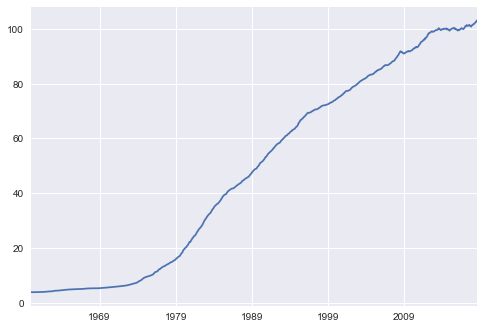

In [296]:
data.plot()
plt.show()

The autocorrelation plot comfirm the non stationnarity of the process since it has a very slow decay.
Moreover, the non stationnarity is due to the one unit root problem according to the ADF test : the pvalue  is 
higher than the critical value 0.01. So we can not reject the unit root of the process.

Remark : we used the constant with trend specification for the ADF test according to the graphic. We also used the BIC criterion which is better than the AIC when there is a large dataset

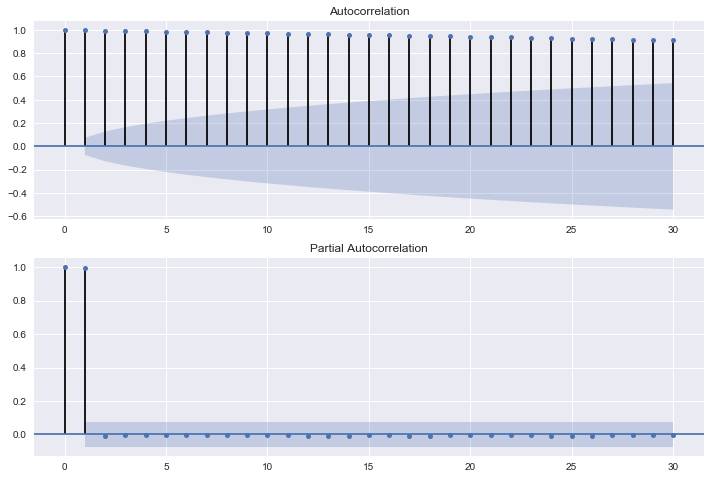

pvalue ADF test :
(-2.4471159288284494, 0.35488632101156942, 12, 692, {'1%': -3.9719122847940267, '5%': -3.4168535152556134, '10%': -3.1307946802036497}, -947.9140982651802)


In [297]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=30, ax=ax2)

plt.show()

adf=sm.tsa.stattools.adfuller(np.ravel(data),regression="ct", autolag="BIC")
print("pvalue ADF test :")
print(adf)

So, we difference once the process :

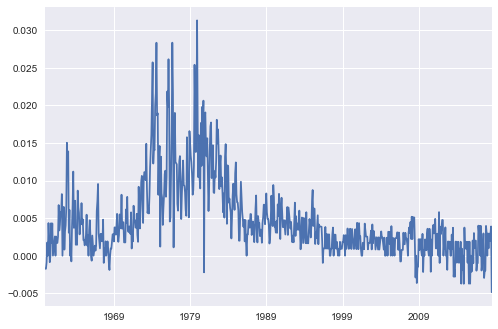

In [298]:
log_data = data.apply(np.log)
logdiff_data = np.diff(log_data)
logdiff_data = pd.Series(logdiff_data, index=pd.date_range('1/1/1960',freq = 'M', periods=704))

logdiff_data.plot()
plt.show()

We cannot decide if the process is now stationnary. We continue our inspection and see that there is always stationnarity problem according to the slow decay of the autocorrelation. More, the ADF test do not reject the unit process.

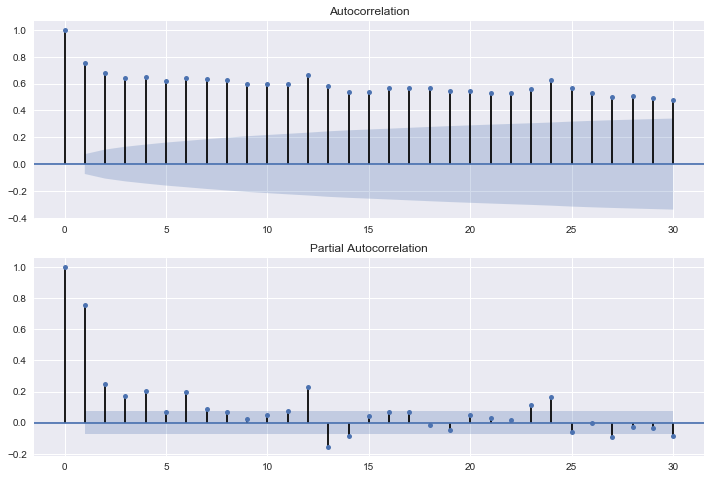

pvalue ADF test :
(-2.1393927850390844, 0.22897229778972611, 12, 691, {'1%': -3.4398489271901713, '5%': -2.8657317673059395, '10%': -2.5690022215962518}, -5932.9448338770371)


In [299]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(logdiff_data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(logdiff_data, lags=30, ax=ax2)

plt.show()

adf=sm.tsa.stattools.adfuller(logdiff_data, regression='c', autolag='BIC') # no more trend according to the plot
print("pvalue ADF test :")
print(adf)

We have to differentiate it a second time :

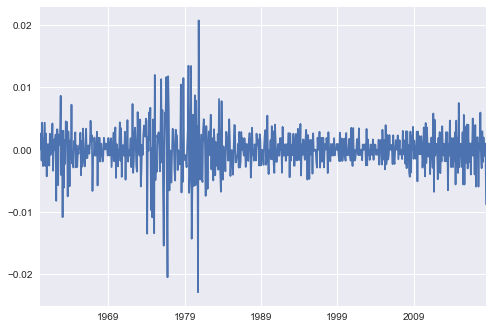

In [300]:
logdiff2_data = np.diff(logdiff_data)
logdiff2_data = pd.Series(logdiff2_data, index=pd.date_range('1/1/1960',freq = 'M', periods=703))

logdiff2_data.plot()
plt.show()

Now, the process is stationnary : we reject the unit root hypothesis. However, by looking at the autocorrelation plot it seems that there is a seasonality problem. Indeed, each 12 lags, there is an increase of the autocorelation

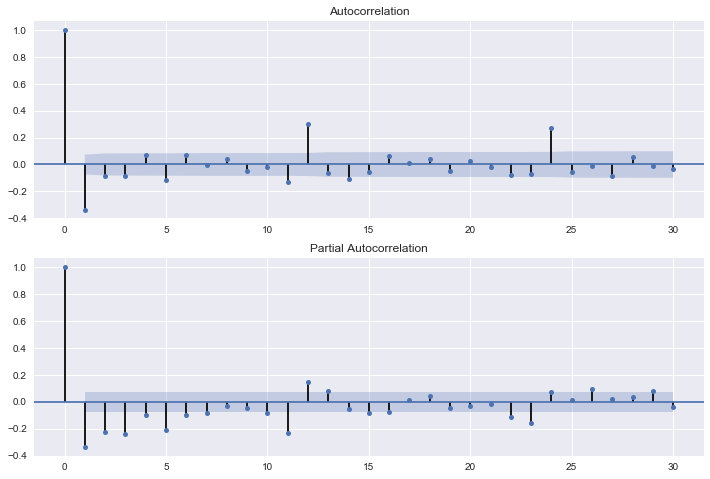

pvalue ADF test :
(-10.975403649750966, 7.6924202905316471e-20, 11, 691, {'1%': -3.4398489271901713, '5%': -2.8657317673059395, '10%': -2.5690022215962518}, -5926.4690702841835)


In [301]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(logdiff2_data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(logdiff2_data, lags=30, ax=ax2)

plt.show()

adf=sm.tsa.stattools.adfuller(logdiff2_data, regression='c', autolag='BIC')
print("pvalue ADF test :")
print(adf)

So, we remove the seasonality by differencing the process by 12 months periodicity

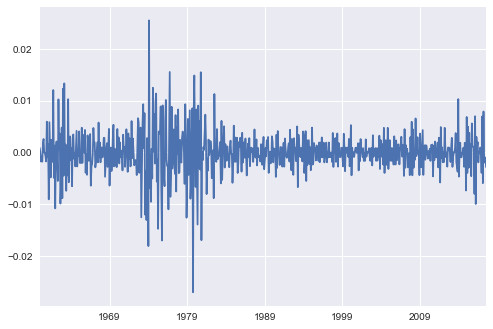

In [302]:
s_logdiff2_data = np.ravel(logdiff2_data[12:len(logdiff2_data)]) - np.ravel(logdiff2_data[:len(logdiff2_data)-12])  

s_logdiff2_data = pd.Series(s_logdiff2_data, index=pd.date_range('1/1/1960',freq = 'M', periods=691))
s_logdiff2_data.plot()
plt.show()

Now, it seems that there is no more stationnarity problem as we can see below. We can now perform the Box-Jenkins methods. Since neither of the ACF or PACF graphic are equal to zero after few lags, the process can not be an AR or MA process. We decide to perform an ARMA specification (all lags are non zero).

It's difficult to decide the number of component of the ARMA process, but the 3 first lags of the PACF are higher than the other one. That's why we have chosen a window from (0,0) to (3,3) couple parameters to perform different possible models.

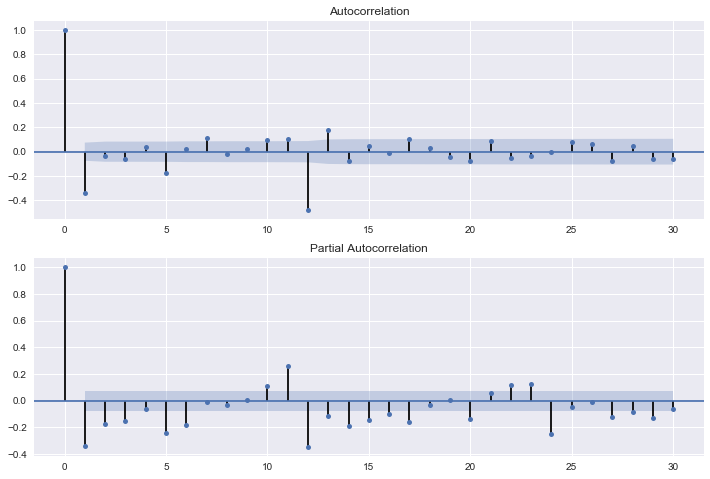

pvalue ADF test :
(-12.810483444303626, 6.4624957580398365e-24, 16, 674, {'1%': -3.4400894360545475, '5%': -2.8658377300287232, '10%': -2.5690586760471605}, -5700.1732162981161)


In [303]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(s_logdiff2_data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(s_logdiff2_data, lags=30, ax=ax2)

plt.show()

adf=sm.tsa.stattools.adfuller(s_logdiff2_data, regression='c', autolag='BIC')
print("pvalue ADF test :")
print(adf)

Among the 16 different models, we choose the one that have the smallest combinaison of AIC and BIC criterion. We can see that the ARMA(1,1) is the only best models minimizing the criterion. We choose it.

In [304]:
ar_order=[0,1,2,3]
ma_order=[0,1,2,3]
arma_res=[list(orders) for orders in product(ar_order,ma_order)]

          
for order in arma_res:
    try:
        arma_model=tsa.ARMA(s_logdiff2_data, order=order).fit(method="mle", disp=-1)
        order.extend([arma_model.aic, arma_model.bic])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
        
res=pd.DataFrame(arma_res,columns=["ar_order","ma_order","aic","bic"])
print(res)

/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood

    ar_order  ma_order          aic          bic
0          0         0 -5587.366851 -5578.290572
1          0         1 -5717.151334 -5703.536914
2          0         2 -5737.370563 -5719.218003
3          0         3 -5754.225596 -5731.534897
4          1         0 -5670.663167 -5657.048748
5          1         1 -5784.015704 -5765.863145
6          1         2 -5767.121537 -5744.430838
7          1         3 -5752.407293 -5725.178454
8          2         0 -5690.168235 -5672.015676
9          2         1 -5749.977651 -5727.286952
10         2         2 -5757.743266 -5730.514427
11         2         3 -5746.298935 -5714.531956
12         3         0 -5704.983336 -5682.292637
13         3         1 -5760.832628 -5733.603789
14         3         2 -5769.287721 -5737.520742
15         3         3 -5759.044415 -5722.739296


/Users/johnsibony/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Now, we fit the ARMA(1,1) model and see if the residuals are really iid (no autocorrelation). Otherwise, the model is not appropriate. But as we can see below it seems approximately good enough :

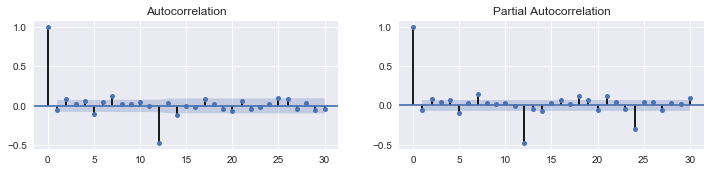

In [305]:
arma_model=tsa.ARMA(s_logdiff2_data, order=[1,1]).fit(method="mle",maxiter=100, disp=-1)

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(321)
fig=sm.graphics.tsa.plot_acf(arma_model.resid, lags=30, ax=ax1)  # RESIDUS
ax2=fig.add_subplot(322)
fig=sm.graphics.tsa.plot_pacf(arma_model.resid,lags=30, ax=ax2)

plt.show()

To comfirm our assumption we perform the Ljung–Box test to decide if the residuals are grouply autocorrelated. We have chosen a 20 jointly lags test and as we can see, the last pvalue reject the null hypothesis of jointly autocorrelation. This comfirm our previous graphical inspection.

In [306]:
acf_coef = sm.tsa.stattools.acf(s_logdiff2_data, nlags=20) # autocorrelation coefficient
temp_acf_coef = acf_coef[1:acf_coef.shape[0]] # acf_coef without the first one coefficient (always 1)
pval = sm.tsa.stattools.q_stat(temp_acf_coef, len(s_logdiff2_data))[1]
print("pvalue Ljung–Box test :")
print(pval)

pvalue Ljung–Box test :
[  2.70324844e-19   1.84112266e-18   4.28059778e-18   1.64109920e-17
   3.52714095e-21   1.41137789e-20   6.82370136e-22   2.53725203e-21
   8.87002848e-21   1.92968028e-21   1.98226089e-22   8.43941281e-55
   6.63914707e-59   4.58480081e-59   1.15549586e-58   5.28776038e-58
   5.83195943e-59   1.90476801e-58   4.06650005e-58   2.47771181e-58]


- **AR-GARCH process**

We have seen just above that the error are not correlated. But what happened if we squared the residuals ?
We can see that there is a clear correlation of the residuals and thus a GARCH model specification is necessary.

Remark : we could have already seen it with the graphic of the 2 differentiate process with the seasonality removed. Indeed, between 1975-1985, the variance was higher than the other period.

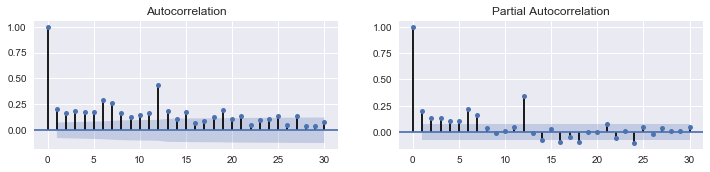

In [307]:
arma_model=tsa.ARMA(s_logdiff2_data, order=[1,1]).fit(method="mle",maxiter=100, disp=-1)

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(321)
fig=sm.graphics.tsa.plot_acf(arma_model.resid**2, lags=30, ax=ax1)  # RESIDUS
ax2=fig.add_subplot(322)
fig=sm.graphics.tsa.plot_pacf(arma_model.resid**2,lags=30, ax=ax2)

plt.show()

So, we perform a AR-GARCH model with the arch_model function by providing mean='AR' for the conditionnal mean process. We use only a GARCH(1,1) model for the conditionnal volatility since it's generally enough. We also used a iid Normality specification for the innovative residuals.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2959.594880342494
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2959.6762318137526
Iteration:      3,   Func. Count:     34,   Neg. LLF: -2959.6799232917283
Iteration:      4,   Func. Count:     50,   Neg. LLF: -2957.2467229451277
Iteration:      5,   Func. Count:     66,   Neg. LLF: -1839.379817154686
Iteration:      6,   Func. Count:     80,   Neg. LLF: -2146.4827824402214
Iteration:      7,   Func. Count:     95,   Neg. LLF: -2409.1172210198183
Iteration:      8,   Func. Count:    111,   Neg. LLF: -1029.330524311929
Iteration:      9,   Func. Count:    125,   Neg. LLF: -1487.1100864032423
Iteration:     10,   Func. Count:    138,   Neg. LLF: -1851.1534413054126
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1851.1534374360829
            Iterations: 14
            Function evaluations: 138
            Gradient evaluations: 10
                           AR - GARCH Mod

/Users/johnsibony/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


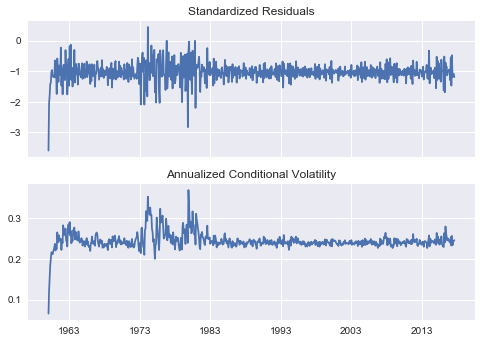

In [308]:
am1 = arch_model(s_logdiff2_data, mean='AR', p=1, o=0, q=1, dist='Normal') 
res1 = am1.fit()
print(res1.summary())
fig = res1.plot(annualize='D')
plt.show()

If our model is correct, we the innovative residuals should be Normal. But the histogramme below seems to have higher peak and fatter tails. Moreover, the JB test reject the normality of the residuals.

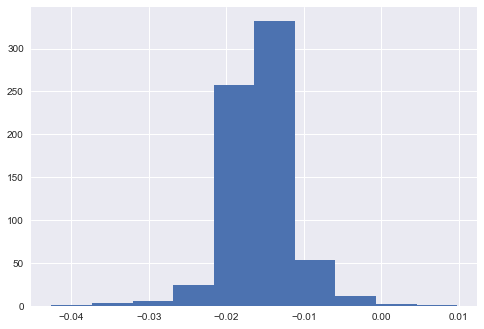

pvalue JB test :


1.8177207446882348e-236

In [309]:
plt.hist(res1.resid)
plt.show()
jb = sm.stats.stattools.jarque_bera(res1.resid, axis=0)
print("pvalue JB test :")
jb[1]

So, we decided to use instead a student distribution of the residuals which has fatter tails :

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2959.594880342494
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2959.6762318137526
Iteration:      3,   Func. Count:     34,   Neg. LLF: -2959.6799232917283
Iteration:      4,   Func. Count:     50,   Neg. LLF: -2957.2467229451277
Iteration:      5,   Func. Count:     66,   Neg. LLF: -1839.379817154686
Iteration:      6,   Func. Count:     80,   Neg. LLF: -2146.4827824402214
Iteration:      7,   Func. Count:     95,   Neg. LLF: -2409.1172210198183
Iteration:      8,   Func. Count:    111,   Neg. LLF: -1029.330524311929
Iteration:      9,   Func. Count:    125,   Neg. LLF: -1487.1100864032423
Iteration:     10,   Func. Count:    138,   Neg. LLF: -1851.1534413054126
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1851.1534374360829
            Iterations: 14
            Function evaluations: 138
            Gradient evaluations: 10
                           AR - GARCH Mod

/Users/johnsibony/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


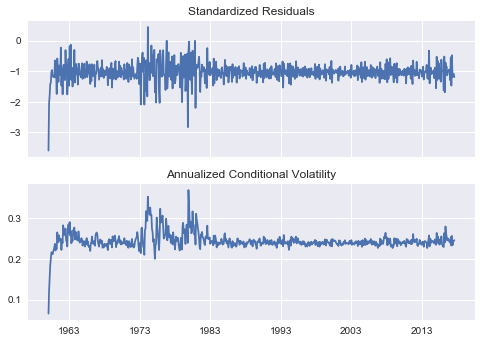

In [310]:
am2 = arch_model(s_logdiff2_data, mean='AR', p=1, o=0, q=1, dist='t') 
res2 = am1.fit()
print(res2.summary())
fig = res2.plot(annualize='D')
plt.show()

#### 2) Daily Return Index

We have decided to import the SP500 index with the Yahoo finance API, from '1990-01-01' to '2018-11-30'.
We have taken the daily log return and plot it. As we can see below, a GARCH model is clearly more appropriate since the variance is time depending (higher variance during the crisis of 2009 for example)

[*********************100%***********************]  1 of 1 downloaded


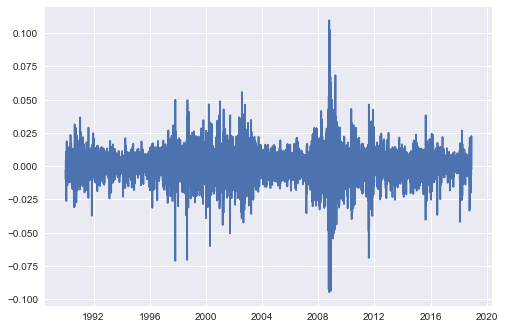

In [311]:
tickers = ['^GSPC']
start_date = '1990-01-01'
end_date = '2018-11-30'
SP = pd.DataFrame(yf.download(tickers,start_date,end_date))

SP['LogReturn']=SP['Adj Close'].map(np.log) - SP['Adj Close'].shift(1).map(np.log)
SP = SP[1:] # remove the first NA value
y=SP['LogReturn']

plt.plot(y)
plt.show()

We perform a GARCH(1,1) model with only a constant for the conditionnal mean (typical specification for index daily log return). We also choose a normal distribution of the residuals.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -23989.423701817257
Iteration:      2,   Func. Count:     21,   Neg. LLF: -23994.29516219753
Iteration:      3,   Func. Count:     35,   Neg. LLF: -23994.298808722953
Iteration:      4,   Func. Count:     51,   Neg. LLF: -23485.812628398002
Iteration:      5,   Func. Count:     67,   Neg. LLF: -2832.754528503797
Iteration:      6,   Func. Count:     80,   Neg. LLF: -10229.97160952362
Iteration:      7,   Func. Count:     96,   Neg. LLF: -23982.92747048004
Iteration:      8,   Func. Count:    112,   Neg. LLF: 10203.134798988922
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 10203.134925685872
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                   -3975.319
Mean Model:             Constant Me

/Users/johnsibony/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


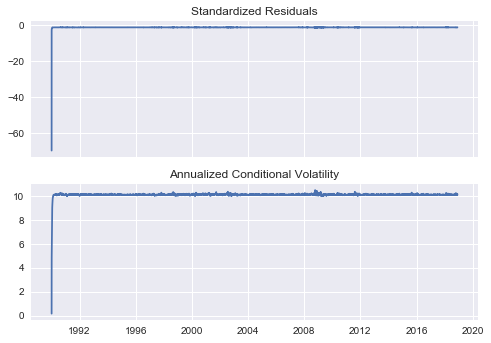

In [312]:
am1 = arch_model(y, mean='Constant', p=1, o=0, q=1, dist='Normal') 
res1SP = am1.fit()
print(res1SP.summary())
fig = res1SP.plot(annualize='D')
plt.show()

The residuals must follow a normal law by our specification. But the JB test reject the normality and thus we have to use another modelization of the erros. According to the histogramme, a Student law is more appropriate.

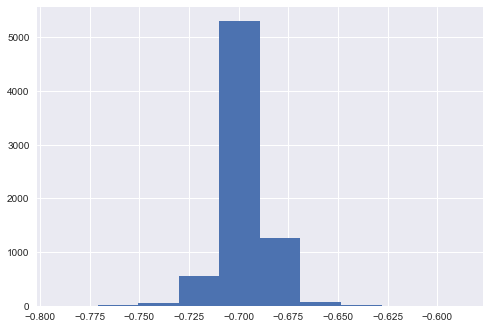

pvalue JB test :


0.0

In [313]:
plt.hist(res1SP.resid)
plt.show()
jb = sm.stats.stattools.jarque_bera(res1SP.resid, axis=0)
print("pvalue JB test :")
jb[1]

We perform the same model as before but with a student law distribution. First, we can notice an huge decrease in the AIC/BIC criterion between the to models (from +20 000 to -20 000). Thus, the Student modelization is to be preferred

Iteration:      1,   Func. Count:      7,   Neg. LLF: -24147.004188852
Iteration:      2,   Func. Count:     24,   Neg. LLF: 79015.86582654214
Iteration:      3,   Func. Count:     34,   Neg. LLF: 66655.41384470733
Iteration:      4,   Func. Count:     41,   Neg. LLF: 49263.00296785967
Iteration:      5,   Func. Count:     57,   Neg. LLF: 48464.540611820776
Iteration:      6,   Func. Count:     65,   Neg. LLF: 39029.51078522617
Iteration:      7,   Func. Count:     72,   Neg. LLF: 30204.589618214344
Iteration:      8,   Func. Count:     79,   Neg. LLF: 23171.097963828877
Iteration:      9,   Func. Count:     87,   Neg. LLF: -18569.855431737084
Iteration:     10,   Func. Count:     99,   Neg. LLF: -21309.56425945669
Iteration:     11,   Func. Count:    116,   Neg. LLF: 24880.9028395286
Iteration:     12,   Func. Count:    124,   Neg. LLF: 24777.238266135355
Iteration:     13,   Func. Count:    131,   Neg. LLF: 24063.37897405973
Iteration:     14,   Func. Count:    138,   Neg. LLF: 21937

/Users/johnsibony/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


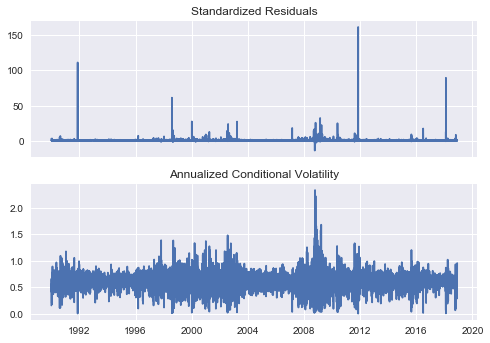

In [314]:
am2 = arch_model(y, mean='Constant', p=1, o=0, q=1, dist='t') 
res2SP = am2.fit()
print(res2SP.summary())
fig = res2SP.plot(annualize='D')
plt.show()

Now, we plot the ACf and PACF function of the student residuals to see if they seems really iid.
As we can see below there is no clear autocorrelation of the error.

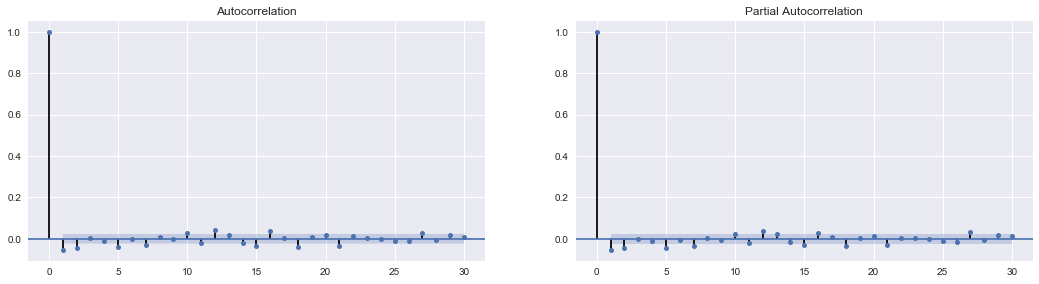

In [315]:
fig=plt.figure(figsize=(18,15))
ax1=fig.add_subplot(321)
fig=sm.graphics.tsa.plot_acf(res2SP.resid, lags=30, ax=ax1)  # RESIDUS
ax2=fig.add_subplot(322)
fig=sm.graphics.tsa.plot_pacf(res2SP.resid,lags=30, ax=ax2)

plt.show()

To comfirm our assumption, we also plot the ACF and PACF of the squared residuals. There is also no clear autocorrealtion of the squared errors. 

Thus, the Student model is the most appropriate for the SP500 index.

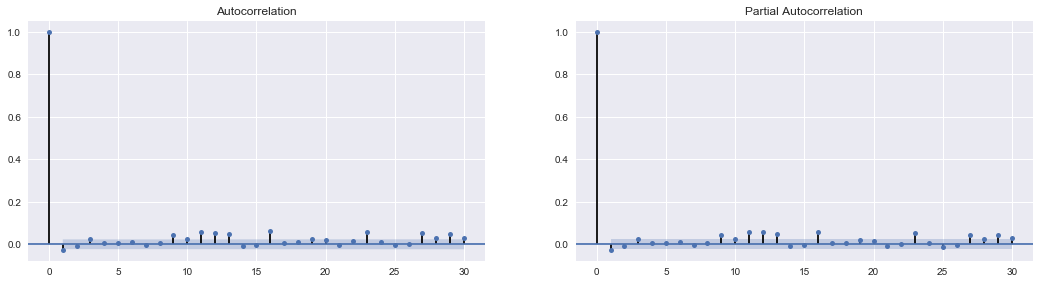

In [316]:
fig=plt.figure(figsize=(18,15))
ax1=fig.add_subplot(321)
fig=sm.graphics.tsa.plot_acf(res2SP.resid**2, lags=30, ax=ax1)  # RESIDUS
ax2=fig.add_subplot(322)
fig=sm.graphics.tsa.plot_pacf(res2SP.resid**2,lags=30, ax=ax2)

plt.show()